### Загрузка данных

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import requests
from tqdm import tqdm
import math as mth
import scipy.stats as st
import plotly.io as pio
pio.renderers.default = "jupyterlab+png"

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
df_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')

In [3]:
display(df.head())
print(df.info())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


In [4]:
display(df_sources.head())
print(df_sources.info())

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None


По результатам изучения общей информации можно сделать следующие выводы:  
- Количество строк в столбцах не различается. Значит, в данных нет пропущенных значений. 
- В данных присутствуют некорректные названия столбцов и некорректный тип данных в столбце `event_time`, которые нужно исправить.

### Предобработка данных
#### Заменим названия столбцов

In [5]:
df = df.rename(columns={
                            'event.time':'event_time',
                            'event.name':'event_name',
                            'user.id':'user_id',
                            })
df.columns

Index(['event_time', 'event_name', 'user_id'], dtype='object')

In [6]:
df_sources = df_sources.rename(columns={'userId':'user_id'})
df_sources.columns

Index(['user_id', 'source'], dtype='object')

#### Приведем данные к нужному типу

In [7]:
df['event_time'] = pd.to_datetime(df['event_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


#### Проверим данные на пропуски

In [8]:
df.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [9]:
df_sources.isna().sum()

user_id    0
source     0
dtype: int64

В данных отсутствуют пропуски.

#### Проверим данные на явные и неявные дубликаты

In [10]:
print('Количество явных дубликатов в двух датасетах:', df.duplicated().sum(),',',df_sources.duplicated().sum())

Количество явных дубликатов в двух датасетах: 0 , 0


Проверим неявные дубликаты в столбце с событиями.

In [11]:
df['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Объединим события 'contacts_show' и 'show_contacts' в одно, а также все действия, связанные с поиском по сайту.

In [12]:
df['event_name'] = df['event_name'].replace('show_contacts', 'contacts_show')
df['event_name'] = df['event_name'].replace('^search_\d+', 'search', regex=True)
df['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [13]:
# проверка неявных дубликатов в столбце с источниками
df_sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

#### Объединим данные о событиях и об источниках

In [14]:
df = df.merge(df_sources, on='user_id', how='left')
df.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [15]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


#### Добавим отдельный столбец дат

In [16]:
df['event_date'] = pd.to_datetime(df['event_time'].dt.date)
df['event_date'] = df['event_date'].dt.strftime('%Y-%m-%d')
df.head()

,event_time,event_name,user_id,source,event_date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07


### Исследовательский анализ данных
#### Изучим количество событий в логе

In [17]:
print('Общее количество событий в логе:', len(df['event_name']))
print('Количество уникальных событий в логе:', len(df['event_name'].unique()))

Общее количество событий в логе: 74197
Количество уникальных событий в логе: 9


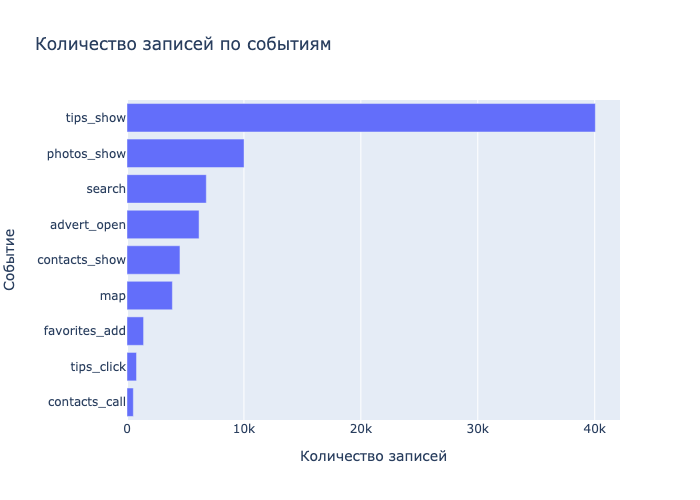

In [18]:
df_events = (df
 .groupby('event_name',  as_index=False)
 .agg({'user_id': 'count'})
 .sort_values(by='user_id', ascending=True)
)
fig = px.bar(df_events, 
             x='user_id', 
             y='event_name', 
             title='Количество записей по событиям',
             labels={
                     "event_name": "Событие",
                     "user_id": "Количество записей"
             }
            )
fig.update_layout(showlegend = False)
fig.show()

Больше всего записей – у события tips_show. Это событие отображается автоматически для всех пользователей. На втором месте – photos_show. Меньше всего записей – у события contacts_call.

#### Изучим, сколько в среднем событий приходится на пользователя

In [19]:
print('Количество уникальных пользователей в логе:', df['user_id'].nunique())

Количество уникальных пользователей в логе: 4293


In [20]:
print('Описание данных о количестве событий на пользователя:')
display(df.groupby('user_id')['event_name'].count().describe())
print('Медианное количество событий на пользователя:', df.groupby('user_id')['event_name'].count().median())
print('Медианное количество уникальных событий на пользователя:',df.groupby('user_id')['event_name'].value_counts().median())

Описание данных о количестве событий на пользователя:


count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: event_name, dtype: float64

Медианное количество событий на пользователя: 9.0
Медианное количество уникальных событий на пользователя: 3.0


#### Изучим, данными за какой период мы располагаем

In [21]:
print('Дата первого события:', df['event_date'].min())
print('Дата последнего события:', df['event_date'].max())

Дата первого события: 2019-10-07
Дата последнего события: 2019-11-03


#### Изучим, как события распределены по дням

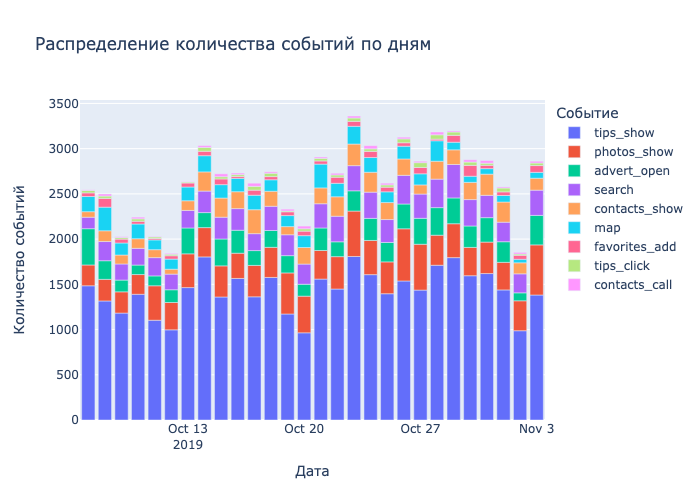

In [22]:
df_events_days = (df
                .groupby(['event_date', 'event_name'], as_index=False)
                .agg(count=('user_id', 'count'))
                .sort_values('count', ascending = False)
               )
fig = px.bar(df_events_days, 
             x='event_date', 
             y='count', 
             color = 'event_name', 
             title='Распределение количества событий по дням',
             labels={
                     "event_date": "Дата",
                     "event_name": "Событие",
                     "count": "Количество событий"
                 }
            )
fig.show()

Во второй половине октября количество событий возросло, больше всего событий происходило 23 октября. Можно отметить резкий спад количества событий 2 ноября, а затем рост.

#### Опишем соотношение пользователей, установивших приложение из разных источников

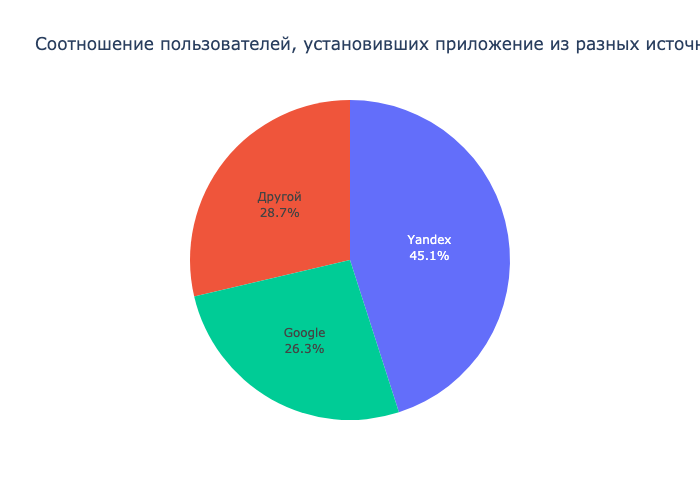

In [23]:
users_yandex = df[df['source'] == 'yandex']['user_id'].nunique()
users_google = df[df['source'] == 'google']['user_id'].nunique()
users_other = df[df['source'] == 'other']['user_id'].nunique()

fig = go.Figure(data=[go.Pie(labels=['Yandex', 'Google', 'Другой'], 
                             values=[users_yandex, users_google, users_other], 
                             textinfo='label+percent')])
fig.update_layout(title_text = 'Соотношение пользователей, установивших приложение из разных источников', 
                  showlegend = False)
fig.show() 

Количество пользователей, установивших приложение из источника Yandex, больше, чем из источника Google и других источников.

#### Опишем соотношение пользователей, смотревших и не смотревших контакты

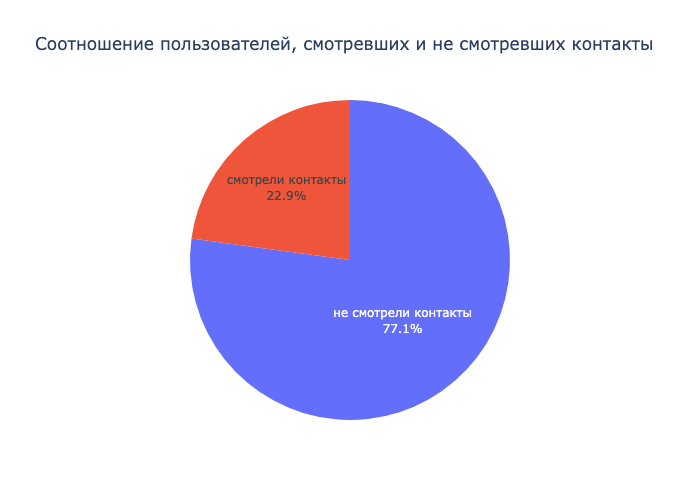

In [24]:
users_with_contacts_show = df[df['event_name'] == 'contacts_show']['user_id'].nunique()
other_users = df['user_id'].nunique() - users_with_contacts_show

fig = go.Figure(data=[go.Pie(
                            labels=['смотрели контакты', 'не смотрели контакты'], 
                            values=[users_with_contacts_show, other_users], 
                            textinfo='label+percent')])
fig.update_layout(title_text = 'Соотношение пользователей, смотревших и не смотревших контакты', 
                  showlegend = False)
fig.show() 

Количество пользователей, которые не смотрели контакты (77%), гораздо больше количества пользователей, смотревших контакты (23%). 

### Анализ влияния событий на совершение целевого события
#### Выделим сессии и сформируем новый датафрейм без повторяющихся событий 

In [25]:
# отсортируем датасет по user_id и event_time
df = df.sort_values(['user_id', 'event_time'])
# создадим датафрейм для расчета разницы между событиями
df_diff = df.copy()
# посчитаем разницу между соседними событиями в минутах
df_diff['event_time_diff'] = (df_diff.groupby('user_id')['event_time']
                              .diff().dt.total_seconds().div(60))
df_diff = df_diff.dropna()
df_diff.head()

,event_time,event_name,user_id,source,event_date,event_time_diff
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0.751059
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0.577826
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2.250216
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2.169701
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,0.204914


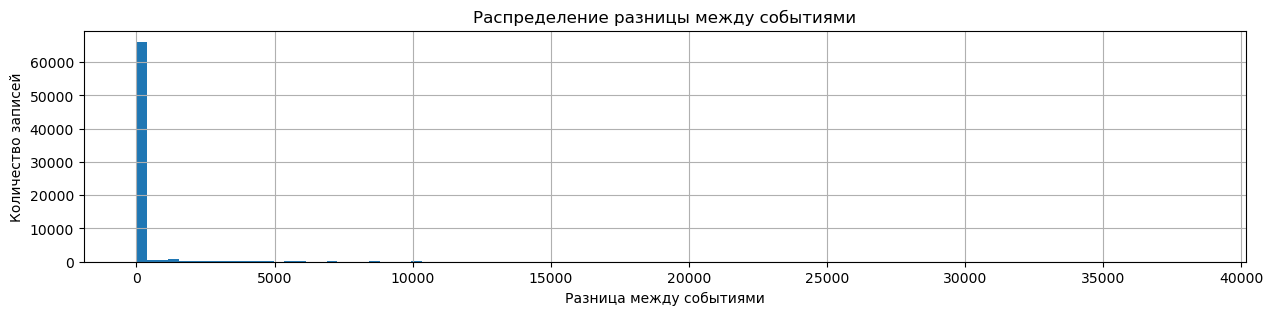

In [26]:
df_diff.hist('event_time_diff', bins=100, figsize = (15,3))
plt.title('Распределение разницы между событиями')
plt.xlabel('Разница между событиями')
plt.ylabel('Количество записей');

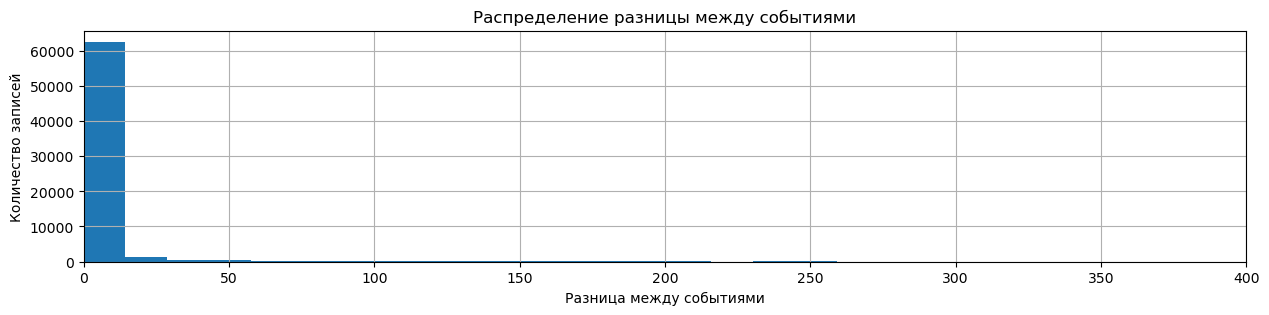

In [27]:
# добавим ограничение в 1 день
df_diff = df_diff.query('event_time_diff < 1440')
df_diff.hist('event_time_diff', bins=100, figsize = (15,3))
plt.title('Распределение разницы между событиями')
plt.xlabel('Разница между событиями')
plt.ylabel('Количество записей')
plt.xlim(0, 400);

In [28]:
print('90-й и 95-й перцентили разницы между событиями в минутах:', np.percentile(df_diff['event_time_diff'], [90, 95]).round(1))

90-й и 95-й перцентили разницы между событиями в минутах: [ 8.5 42.8]


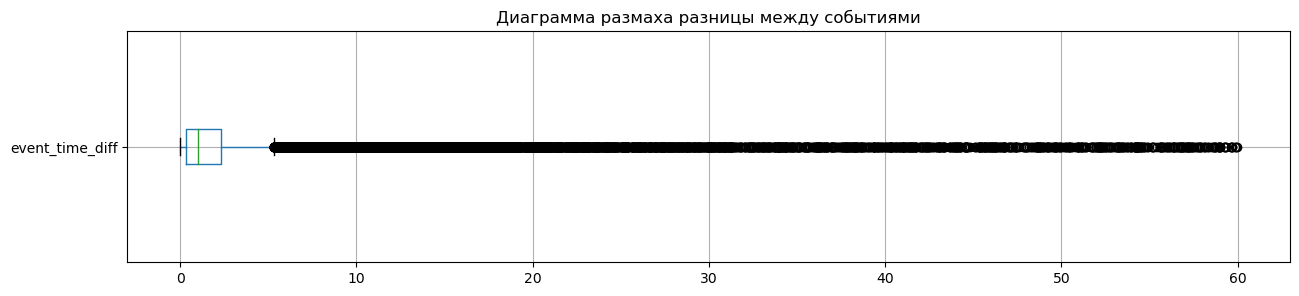

In [29]:
# добавим ограничение в 1 час
df_diff = df_diff.query('event_time_diff < 60')
fig, ax = plt.subplots(figsize = (15,3))
ax = df_diff[['event_time_diff']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха разницы между событиями');

In [30]:
print('90-й и 95-й перцентили разницы между событиями в минутах:', np.percentile(df_diff['event_time_diff'], [90, 95]).round(1))

90-й и 95-й перцентили разницы между событиями в минутах: [5.2 9.7]


Возьмем 90-й перцентиль и определим тайм-аут сессии в 5.2 минут.

In [31]:
pctile = np.percentile(df_diff['event_time_diff'], 90).round(1)
timeout = f'{pctile}Min'
timeout

'5.2Min'

In [32]:
#выделим сессии
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta(timeout)).cumsum()
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
df

,event_time,event_name,user_id,source,event_date,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
...,...,...,...,...,...,...
72584,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,16078
72589,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,16078
72684,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,16079
72688,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-11-03,16079


Сформируем датафрейм без повторяющихся событий в рамках сессии.

In [33]:
df_unique_events = df.pivot_table(
    index=['user_id', 'session_id', 'event_name'],
    aggfunc={'event_time': 'first'}
    ).sort_values(['user_id', 'event_time']).reset_index()
df_unique_events.head()

,user_id,session_id,event_name,event_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,tips_show,2019-10-07 13:39:45.989359
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,map,2019-10-09 18:33:55.577963
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,tips_show,2019-10-09 18:40:28.738785
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,tips_show,2019-10-21 19:52:30.778932
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,map,2019-10-21 19:53:38.767230


Проанализируем количество сессий у пользователей.

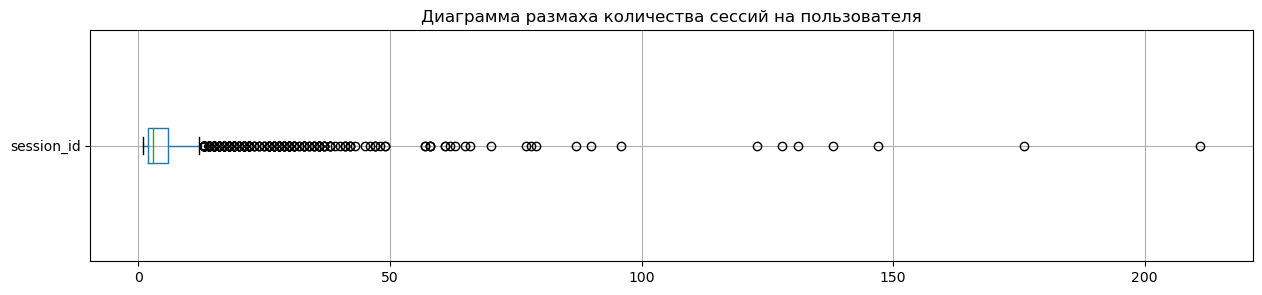

In [34]:
df_sess = (df_unique_events
 .groupby('user_id',  as_index=False)
 .agg({'session_id': 'count'})
 .sort_values(by='session_id', ascending=False)
)
fig, ax = plt.subplots(figsize = (15,3))
ax = df_sess[['session_id']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха количества сессий на пользователя');

In [35]:
df_sess['session_id'].describe()

count    4293.000000
mean        5.599348
std         9.257335
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max       211.000000
Name: session_id, dtype: float64

Медианное количество сессий на пользователя – 5.6. В данных о количестве сессий можем заметить аномалии – у некоторых пользователей встречается 50-200 сессий. Оставим аномалии как есть.

#### В разрезе сессий отберем основные сценарии, которые приводят к просмотру контактов

Подготовим функции для построения диаграммы Санкея.

In [36]:
def add_features(df):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    # сортируем по session_id и времени
    sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)
  
# преобразуем таблицу
df_comp = add_features(df_unique_events)
df_comp.head()

,user_id,session_id,event_time,step,source,target
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45.989359,1,tips_show,NaN
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55.577963,1,map,tips_show
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:40:28.738785,2,tips_show,NaN
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30.778932,1,tips_show,map
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:53:38.767230,2,map,NaN


In [37]:
def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

In [38]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [39]:
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

In [40]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [41]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  
# создаем словарь
data_for_plot = lists_for_plot()

Шаг: 100%|████████████████████████████████████████| 6/6 [00:01<00:00,  3.53it/s]


In [42]:
def plot_sankey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Санкея 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, autosize = True)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
sankey_diagram = plot_sankey_diagram()

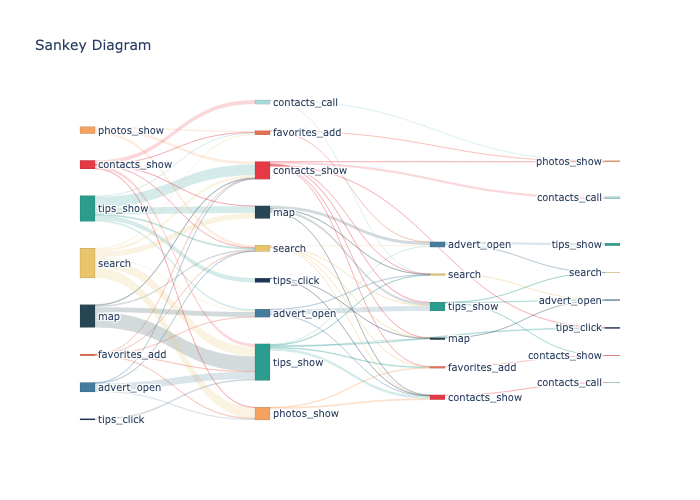

In [43]:
# построим диаграмму Санкея
sankey_diagram.show()

По диаграмме Санкея определим популярные сценарии:
1. map -> tips_show
2. tips_show -> contacts_show
3. search -> photos_show

Выделим основные сценарии, которые приводят к целевому действию - просмотру контактов:
1. tips_show -> contacts_show
2. photos_show -> contacts_show
3. search -> contacts_show
4. map -> tips_show -> contacts_show

#### Построим воронки по основным сценариям в разрезе уникальных пользователей

Создадим функцию для построения воронки из двух событий.

In [44]:
def funnel(data, event1, event2):
    list1 = data.query('event_name == @event1')['user_id'].unique()
    number1 = data.query('event_name == @event1')['user_id'].nunique()
    number2 = data.query('user_id in @list1 & event_name == @event2')['user_id'].nunique()

    fig = go.Figure(
        go.Funnel(
            y=[
                event1,
                event2,
            ],
            x=[number1, number2],
        )
    )
    fig.update_layout(title_text = "Воронка по сценарию " + event1 + " -> " + event2)
    fig.show()

Построим воронку по сценарию tips_show -> contacts_show.

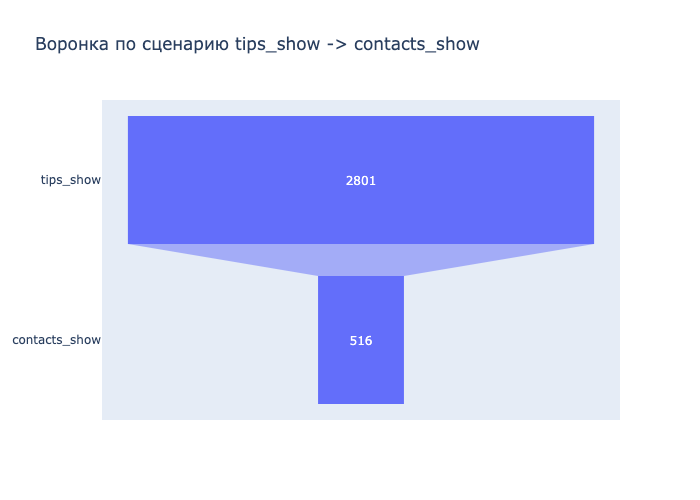

In [45]:
funnel(df_unique_events, 'tips_show', 'contacts_show')

Построим воронку по сценарию photos_show -> contacts_show.

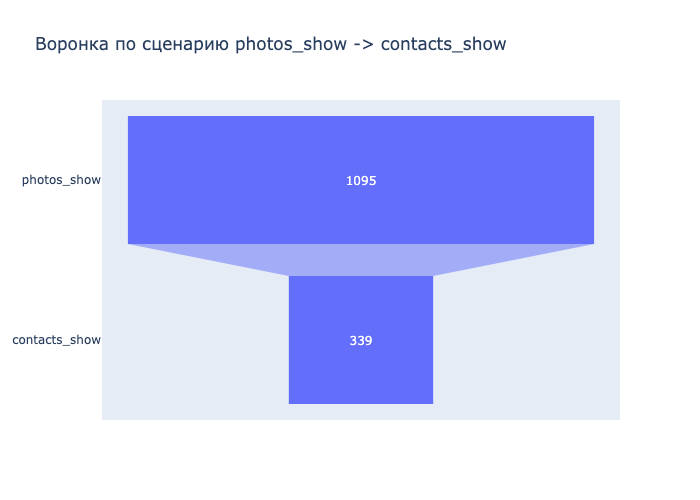

In [46]:
funnel(df_unique_events, 'photos_show', 'contacts_show')

Построим воронку по сценарию search -> contacts_show.

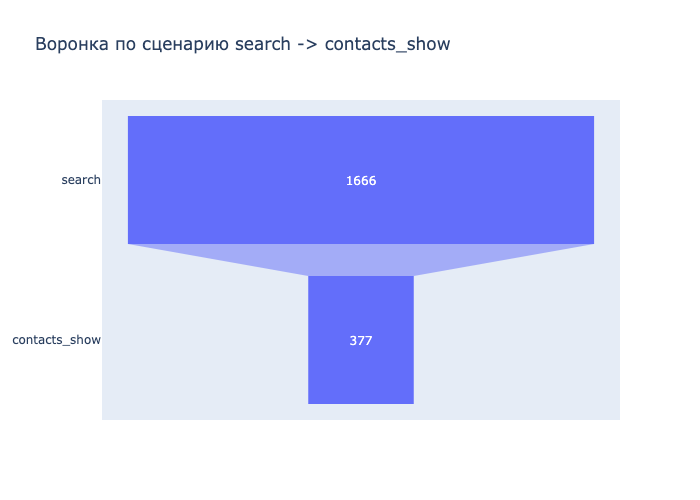

In [47]:
funnel(df_unique_events, 'search', 'contacts_show')

Создадим функцию для построения воронки из трех событий.

In [48]:
def funnel2(data, event1, event2, event3):
    list1 = data.query('event_name == @event1')['user_id'].unique()
    list2 = data.query('user_id in @list1 & event_name == @event2')['user_id'].unique()
    number1 = data.query('event_name == @event1')['user_id'].nunique()
    number2 = data.query('user_id in @list1 & event_name == @event2')['user_id'].nunique()
    number3 = data.query('user_id in @list2 & event_name == @event3')['user_id'].nunique()

    fig = go.Figure(
        go.Funnel(
            y=[
                event1,
                event2,
                event3,
            ],
            x=[number1, number2, number3],
        )
    )
    fig.update_layout(title_text = "Воронка по сценарию " + event1 + " -> " + event2 + " -> " + event3)
    fig.show()

Построим воронку по сценарию map -> tips_show -> contacts_show.

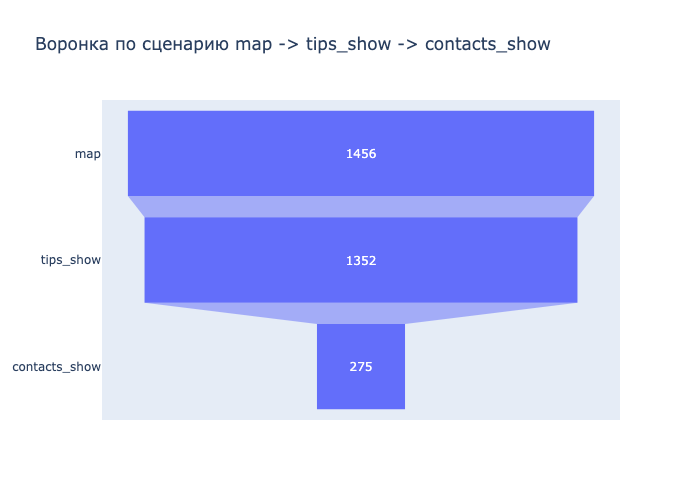

In [49]:
funnel2(df_unique_events, 'map', 'tips_show', 'contacts_show')

#### Сформируем две группы – пользователи, которые смотрели контакты, и пользователи, которые не смотрели контакты. Определим относительную частоту событий в двух группах

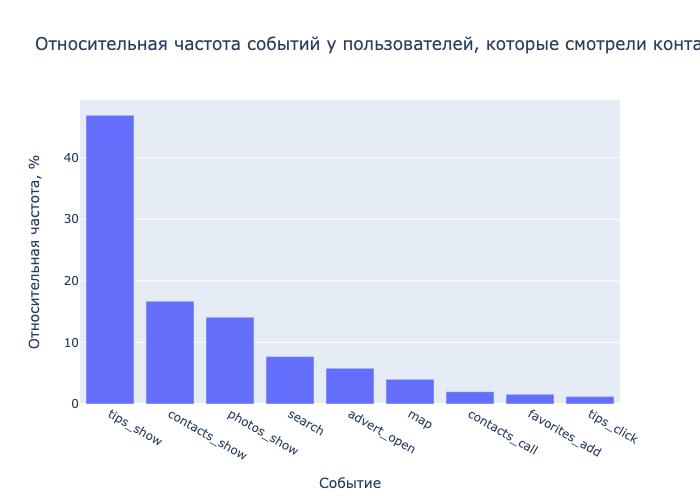

In [50]:
list_contacts_show = df[df['event_name'] == 'contacts_show']['user_id'].unique()
df_contacts_show = (df
                    .query('user_id in @list_contacts_show')
                    .groupby('event_name')
                    .agg(count=('event_name', 'count'))
                    .reset_index()
                    )
df_contacts_show['ratio_%'] = ((df_contacts_show['count'] / df_contacts_show['count'].sum() * 100)).round(1)
df_contacts_show = df_contacts_show.sort_values(by='ratio_%', ascending=False)
fig = px.bar(df_contacts_show, 
             x='event_name', 
             y='ratio_%', 
             title='Относительная частота событий у пользователей, которые смотрели контакты',
             labels={
                     "event_name": "Событие",
                     "ratio_%": "Относительная частота, %"
            }
            )
fig.update_layout(showlegend = False)
fig.show()

У пользователей, которые смотрели контакты, чаще всего встречается событие tips_show, за ним идут photos_show, search и advert_open. На последнем месте – tips_click.

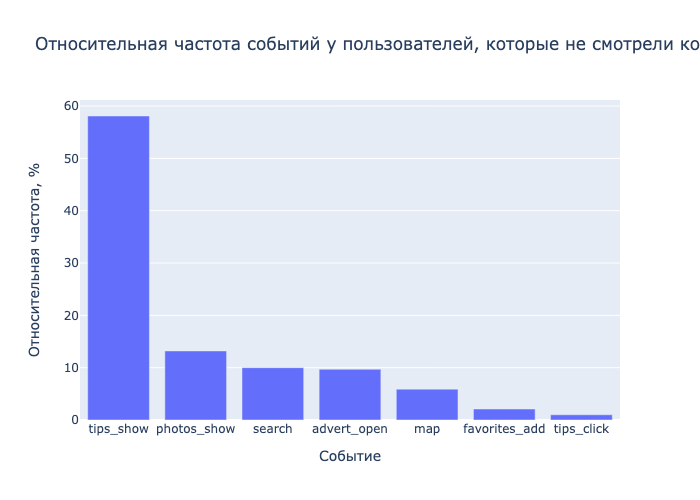

In [51]:
df_no_contacts_show = (df
                    .query('user_id not in @list_contacts_show')
                    .groupby('event_name')
                    .agg(count=('event_name', 'count'))
                    .reset_index()
                    )
df_no_contacts_show['ratio_%'] = ((df_no_contacts_show['count'] / df_no_contacts_show['count'].sum() * 100)).round(1)
df_no_contacts_show = df_no_contacts_show.sort_values(by='ratio_%', ascending=False)
fig = px.bar(df_no_contacts_show, 
             x='event_name', 
             y='ratio_%', 
             title='Относительная частота событий у пользователей, которые не смотрели контакты',
            labels={
                     "event_name": "Событие",
                     "ratio_%": "Относительная частота, %"
            }
            )
fig.update_layout(showlegend = False)
fig.show()

У пользователей, которые не смотрели контакты, относительная частота событий практически такая же. Чаще всего встречается событие tips_show, за ним идут photos_show, search и advert_open. На последнем месте – tips_click. Можно заметить, что событие search и событие advert_open встречается с одинаковой частотой (~10%).

### Проверка гипотез
#### Одни пользователи совершают действия tips_show и tips_click , другие — только tips_show. Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп

Создадим функцию для проверки гипотезы о различии конверсии в просмотры контактов у двух групп. Для проверки гипотезы будем использовать z-тест. Установим уровень значимости 0.05. 

In [52]:
def stat_function_contacts(data1, data2, alpha):
    
    #число пользователей в 1 и 2 группе
    users = np.array([data1['user_id'].nunique(), 
                        data2['user_id'].nunique()])
    
    # число пользователей, которые совершили событие в 1 и 2 группе
    event = np.array([data1[data1['event_name'] == 'contacts_show']['user_id'].nunique(), 
                        data2[data2['event_name'] == 'contacts_show']['user_id'].nunique()])
    
    # пропорция событий в первой группе:
    p1 = event[0]/users[0]

    # пропорция событий во второй группе:
    p2 = event[1]/users[1]

    # пропорция событий в комбинированном датасете:
    p_combined = (event[0] + event[1]) / (users[0] + users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Показатель конверсии в первой группе: ', (event[0]/users[0]).round(3))
    print('Показатель конверсии во второй группе: ', (event[1]/users[1]).round(3))
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями в просмотры контактов у двух групп есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию в просмотры контактов у двух групп разной')

Сформулируем гипотезы.  
Нулевая: нет оснований считать конверсию в просмотры контактов у двух групп разной.  
Альтернативная: между конверсиями в просмотры контактов у двух групп есть значимая разница.  

In [53]:
# сформируем две группы
df_tips_show_users = df.groupby('user_id', as_index=False).filter(lambda x: 'tips_show' in x['event_name'].values)[['user_id', 'event_name', 'session_id']]
df_tips_show_click = df_tips_show_users.groupby('user_id').filter(lambda x: 'tips_click' in x['event_name'].values).reset_index()
df_tips_show_not_click = df_tips_show_users.groupby('user_id').filter(lambda x: 'tips_click' not in x['event_name'].values).reset_index()
# применим функцию
stat_function_contacts(df_tips_show_click, df_tips_show_not_click, 0.05)

Показатель конверсии в первой группе:  0.306
Показатель конверсии во второй группе:  0.17
p-значение:  9.218316554537864e-09
Отвергаем нулевую гипотезу: между конверсиями в просмотры контактов у двух групп есть значимая разница


**Вывод**  

По результатам проверки статистической гипотезы можно сделать вывод, что у группы пользователей, которые совершают действия tips_show и tips_click, и у группы пользователей, которые совершают только tips_show, различается конверсия в просмотры контактов.

#### Одни пользователи совершают действие map, другие — не совершают действие map. Проверим гипотезу: конверсия в просмотры контактов различается у этих двух групп

Для проверки гипотезы будем использовать z-тест. Установим уровень значимости 0.05. Используем созданную ранее функцию для проверки гипотезы о различии конверсии в просмотры контактов у двух групп.

Сформулируем гипотезы.  
Нулевая: нет оснований считать конверсию в просмотры контактов у двух групп разной.  
Альтернативная: между конверсиями в просмотры контактов у двух групп есть значимая разница.  

In [54]:
# сформируем две группы
df_map = df.groupby('user_id').filter(lambda x: 'map' in x['event_name'].values).reset_index()
df_not_map = df.groupby('user_id').filter(lambda x: 'map' not in x['event_name'].values).reset_index()
# применим функцию
stat_function_contacts(df_map, df_not_map, 0.05)

Показатель конверсии в первой группе:  0.198
Показатель конверсии во второй группе:  0.244
p-значение:  0.0007899493753891207
Отвергаем нулевую гипотезу: между конверсиями в просмотры контактов у двух групп есть значимая разница


**Вывод**  

По результатам проверки статистической гипотезы можно сделать вывод, что у группы пользователей, которые совершают действие map, и у группы пользователей, которые не совершают действие map, различается конверсия в просмотры контактов.

### Общий вывод и презентация

**Основные задачи исследования:**
1. Проанализировать связь целевого события — просмотра контактов — и других действий пользователей. 
2. Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.  

**В результате исследования были получены следующие выводы:**  

Данные представлены за период с 7 октября по 3 ноября 2019 года. Мы проанализировали 9 событий, которые совершают пользователи. Больше всего записей – у события tips_show, затем идет photos_show. Меньше всего записей – у события contacts_call. Во второй половине октября количество событий возросло, больше всего событий происходило 23 октября. Можно отметить резкий спад количества событий 2 ноября, а затем рост. Количество пользователей, установивших приложение из источника Yandex, больше, чем из источника Google и других источников.

Количество пользователей, которые не смотрели контакты (77%), гораздо больше количества пользователей, смотревших контакты (23%). Основные сценарии, которые приводят к целевому действию - просмотру контактов:
1. tips_show -> contacts_show
2. photos_show -> contacts_show
3. search -> contacts_show
4. map -> tips_show -> contacts_show

У пользователей, которые смотрели контакты, чаще всего встречается событие tips_show. Это событие отображается автоматически для всех пользователей. За ним идут photos_show, search и advert_open. На последнем месте – tips_click.

По результатам проверки статистических гипотез можно сделать следующие выводы:
- У группы пользователей, которые совершают действия tips_show и tips_click, и у группы пользователей, которые совершают только tips_show, различается конверсия в просмотры контактов.  
- У группы пользователей, которые совершают действие map, и у группы пользователей, которые не совершают действие map, различается конверсия в просмотры контактов. 

**Основные рекомендации**
- События advert_open (открытие карточки объявление) и favorites_add (добавление в избранное) не входят в популярные сценарии, которые приводят к просмотру контактов. Кроме того, advert_open находится на 4 месте, а favorites_add на 7 месте по относительной частоте у пользователей, которые смотрят контакты. 
- При большой встречаемости события tips_show (показ рекомендованных объявлений) событие tips_click (переход по рекомендованному объявлению) находится на последнем месте по относительной частоте у пользователей, которые смотрят контакты, и не входит в популярные сценарии. 
- Исходя из этого, рекомендуем улучшить в приложении функционал добавления в избранное и отображение карточек объявлений для повышения конверсии, а также оптимизировать показ рекомендуемых объявлений, чтобы увеличить переход пользователей на такие объявления.

**Презентация:** https://drive.google.com/file/d/16XKW21sN_l-PL1k-QBSqTMLzdtUd3-3v/view?usp=sharing